## Set Up

### Install Packages

In [107]:
# Install required packages in Google Colab
# Uncomment the following lines if running in Google Colab

# !pip install leafmap
# !pip install rasterio
# !pip install localtileserver
# !pip install rasterstats
# !pip install mapclassify

### Download Datasets

In [108]:
# import os

# # Clone the repository containing data
# repo_url = "https://github.com/jingxuehan0707/ccgt-workshop-opensr-gis"
# repo_name = repo_url.split('/')[-1]

# # Check if the repository already exists to avoid errors
# if not os.path.exists(repo_name):
#     !git clone {repo_url}
#     print(f"Repository '{repo_name}' cloned successfully.")
# else:
#     print(f"Repository '{repo_name}' already exists. Skipping clone.")

# cloned_data_path = os.path.join(repo_name, "data")
# if os.path.exists(cloned_data_path):
#     # Ensure the target 'data' directory exists
#     if not os.path.exists("data"):
#         os.makedirs("data")
#     # Move contents from cloned_data_path to 'data'
#     for item in os.listdir(cloned_data_path):
#         source = os.path.join(cloned_data_path, item)
#         destination = os.path.join("data", item)
#         if os.path.isdir(source):
#             !mv {source} {destination} # Use mv for directories
#         else:
#             !mv {source} {destination} # Use mv for files
#     print("Moved data from cloned repository to local 'data' directory.")

#     # Clean up: remove the cloned repository directory after moving data
#     !rm -rf {repo_name}
#     print(f"Cleaned up cloned repository '{repo_name}'.")


Book: [Introduction to GIS Programming: A Practical Python Guide to Open Source Geospatial Tools.](https://gispro.gishub.org/#introduction)

## Dataset Overview

This analysis uses multiple geospatial datasets to assess wildfire risk in Los Angeles County:

### Vector Data
1. **Los Angeles County Boundary** (`la_county_boundary.shp`)
   - Administrative boundary for Los Angeles County
   - Used to clip and focus analysis on the study area
   - Source: [National Historical GIS (NHGIS)](https://data2.nhgis.org/main)

2. **California Census Tracts** (`ca_census_tracts.shp`)
   - Census tract polygons covering California
   - Provides geographic units for demographic and risk analysis
   - Source: [National Historical GIS (NHGIS)](https://data2.nhgis.org/main)

3. **California Railway** (`ca_railway.shp`)
   - Railway network lines across California
   - Used to analyze wildfire risk along railway
   - Source: [Federal Railroad Administration (FRA) ](https://www.arcgis.com/home/item.html?id=feb7060cb7ba49ba94e53651fec963b9)

### Tabular Data
4. **California Census Table** (`ca_census_table.csv`)
   - Population and demographic statistics for census tracts
   - Contains population counts and other socioeconomic indicators
   - Source: [National Historical GIS (NHGIS)](https://data2.nhgis.org/main)

### Raster Data
5. **California Wildfire Hazard Potential** (`ca_whp.tif`)
   - GeoTIFF raster file with 270m spatial resolution
   - Classifies areas into wildfire hazard levels (1-7):
     - 1: Very Low
     - 2: Low
     - 3: Moderate
     - 4: High
     - 5: Very High
     - 6: Developed
     - 7: Water
   - Source: [US Forest Service](https://research.fs.usda.gov/firelab/products/dataandtools/wildfire-hazard-potential)

Before loading the data, we define file paths for all datasets. This approach makes the code more maintainable and easier to update if file locations change. All data files are organized in the `data` directory with subdirectories for different data types (vector, table, and raster).

In [109]:
# Vector
la_county_boundary = "data/vector/la_county_boundary.shp"
ca_census_tracts = "data/vector/ca_census_tracts.shp"
ca_railway = "data/vector/ca_railway.shp"

# Table
ca_census_table = "data/table/ca_census_table.csv"

# Raster
ca_whp = "data/raster/ca_whp.tif"

## GeoPandas and Vectors

**GeoPandas** extends pandas for geospatial vector data (points, lines, polygons).

**Key capabilities:**
- Read/write spatial files
- Spatial operations (buffer, clip, intersection)
- Coordinate transformations
- Interactive mapping

### Import GeoPandas
**`import geopandas as gpd`**: This line brings in the powerful **GeoPandas** library, which lets us easily work with **geospatial data** (like shapefiles and GeoJSON) in Python.

The part of the command that reads `as gpd` is a common Python convention (a widely accepted, unofficial standard) used to **create an alias** or a shorter nickname for the library.

In [110]:
import geopandas as gpd

### Read Vectors

**`gpd.read_file()`** reads geospatial files (Shapefile, GeoJSON, etc.) and returns a GeoDataFrame with a special `geometry` column for spatial data.

In [111]:
# Read LA County Boundary Shapefile
la_county_boundary_gdf = gpd.read_file(la_county_boundary)

Let's check the type. 

In [112]:
type(la_county_boundary_gdf)

geopandas.geodataframe.GeoDataFrame

### GeoDataFrame

A **GeoDataFrame** is pandas DataFrame + spatial geometry:

- Special `geometry` column stores shapes (points, lines, polygons)
- Combines attribute data with geographic information
- Enables both data analysis and spatial operations

*Example:*

| index | latitude | longitude | value | category | geometry |
|---:|---:|---:|---:|:---|:---|
| 0 | 40.7491 | -74.6880 | 31 | Cat_0 | POINT (-74.69 40.75) |
| 1 | 41.9014 | -74.8838 | 62 | Cat_1 | POINT (-74.88 41.90) |
| 2 | 41.4640 | -73.2676 | 11 | Cat_2 | POINT (-73.27 41.46) |
| 3 | 41.1973 | -73.7978 | 97 | Cat_3 | POINT (-73.80 41.20) |
| 4 | 40.3120 | -73.5839 | 39 | Cat_4 | POINT (-73.58 40.31) |

*Figure: GeoDataFrames Data Structure*

<img src="img/geodataframes.png" width=50% >

In [113]:
# Display the GeoDataFrame
la_county_boundary_gdf

GISJOIN STATEFP COUNTYFP  COUNTYNS  GEOID         NAME  \
0  G0600370      06      037  00277283  06037  Los Angeles   

             NAMELSAD LSAD CLASSFP  MTFCC  ... CBSAFP METDIVFP FUNCSTAT  \
0  Los Angeles County   06      H1  G4020  ...  31080    31084        A   

          ALAND        AWATER     INTPTLAT      INTPTLON     Shape_Leng  \
0  1.051349e+10  1.787502e+09  +34.1963983  -118.2618616  863553.138118   

     Shape_Area                                           geometry  
0  1.058205e+10  MULTIPOLYGON (((-118.42613 32.79983, -118.4261...  

[1 rows x 21 columns]

The output shows the GeoDataFrame's structure with multiple columns containing attribute data (like `STATEFP`, `COUNTYFP`, `NAME`, etc.) and a special `geometry` column on the far right that stores the actual polygon shape representing LA County's boundary. Each row represents one geographic feature - in this case, there's just one row for the single LA County boundary polygon.

Let's examine the columns in our GeoDataFrame:

**`.columns`** - Lists all column names in the GeoDataFrame

In [114]:
# Show the columns in the GeoDataFrame
la_county_boundary_gdf.columns

Index(['GISJOIN', 'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')

**`.dtypes`** - Shows the data type of each column

**Read more:** [Pandas Data Types Documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#basics-dtypes)

In [115]:
# Show the data types of each column
la_county_boundary_gdf.dtypes

GISJOIN         object
STATEFP         object
COUNTYFP        object
COUNTYNS        object
GEOID           object
NAME            object
NAMELSAD        object
LSAD            object
CLASSFP         object
MTFCC           object
CSAFP           object
CBSAFP          object
METDIVFP        object
FUNCSTAT        object
ALAND          float64
AWATER         float64
INTPTLAT        object
INTPTLON        object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
dtype: object

### Shapely Geometry

The `geometry` column contains **Shapely** objects—Python representations of geometric shapes.

**Shapely geometry types:**
- **Point** - Single coordinate (x, y)
- **LineString** - Connected sequence of points
- **Polygon** - Closed shape with boundary
- **MultiPolygon** - Collection of multiple polygons

GeoPandas uses Shapely to store and manipulate spatial data, enabling geometric operations like buffers, intersections, and spatial relationships.

**Read more**: [Shapely Geometry](https://shapely.readthedocs.io/en/latest/geometry.html)

In [116]:
# Show the geometry column
la_county_boundary_gdf.geometry

0    MULTIPOLYGON (((-118.42613 32.79983, -118.4261...
Name: geometry, dtype: geometry

In [117]:
# Show the coordinate reference system (CRS)
la_county_boundary_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [118]:
# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
la_county_boundary_gdf.to_crs(epsg=3857, inplace=False)

GISJOIN STATEFP COUNTYFP  COUNTYNS  GEOID         NAME  \
0  G0600370      06      037  00277283  06037  Los Angeles   

             NAMELSAD LSAD CLASSFP  MTFCC  ... CBSAFP METDIVFP FUNCSTAT  \
0  Los Angeles County   06      H1  G4020  ...  31080    31084        A   

          ALAND        AWATER     INTPTLAT      INTPTLON     Shape_Leng  \
0  1.051349e+10  1.787502e+09  +34.1963983  -118.2618616  863553.138118   

     Shape_Area                                           geometry  
0  1.058205e+10  MULTIPOLYGON (((-13183136.043 3868764.652, -13...  

[1 rows x 21 columns]

Now let's read a vector file containing multiple geographic features. 

The California census tracts dataset contains thousands of census tract polygons across the entire state. 

In [119]:
# Read California Census Tracts Shapefile
ca_census_tracts_gdf = gpd.read_file(ca_census_tracts)

Let's take a look at the GeoDataFrame

In [120]:
# Display the first few rows of the GeoDataFrame
ca_census_tracts_gdf.head(5)

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID  NAME  \
0  G0600010400100      06      001  400100  06001400100  4001   
1  G0600010400200      06      001  400200  06001400200  4002   
2  G0600010400300      06      001  400300  06001400300  4003   
3  G0600010400400      06      001  400400  06001400400  4004   
4  G0600010400500      06      001  400500  06001400500  4005   

            NAMELSAD  MTFCC FUNCSTAT      ALAND  AWATER     INTPTLAT  \
0  Census Tract 4001  G5020        S  6945857.0     0.0  +37.8676563   
1  Census Tract 4002  G5020        S   586560.0     0.0  +37.8481378   
2  Census Tract 4003  G5020        S  1110840.0     0.0  +37.8405841   
3  Census Tract 4004  G5020        S   716138.0     0.0  +37.8482840   
4  Census Tract 4005  G5020        S   591424.0     0.0  +37.8485452   

       INTPTLON    Shape_Leng    Shape_Area  \
0  -122.2318813  14242.773440  6.945853e+06   
1  -122.2495916   3990.700032  5.865583e+05   
2  -122.2544782   5311.191050  1.110836e+06   
3  -122.2574447   3812.082499  7.161367e+05   
4  -122.2647353   3292.829056  5.914232e+05   

                                            geometry  
0  POLYGON ((-122.21292 37.85778, -122.21296 37.8...  
1  POLYGON ((-122.24191 37.85191, -122.24191 37.8...  
2  POLYGON ((-122.25081 37.83714, -122.25084 37.8...  
3  POLYGON ((-122.25335 37.85383, -122.25333 37.8...  
4  POLYGON ((-122.26183 37.85258, -122.2617 37.85...

**`.shape`** returns a tuple showing the dimensions of the GeoDataFrame as (rows, columns). 

In [121]:
# Display dimensions of the GeoDataFrame
ca_census_tracts_gdf.shape

(9109, 16)

This tells us how many features (rows) and attributes (columns) are in the dataset. For example, `(9019, 16)` means 9,019 census tracts with 16 columns of data.

### Access Columns

In [122]:
# Access columns of the GeoDataFrame
ca_census_tracts_gdf[['COUNTYFP', 'geometry']]

COUNTYFP                                           geometry
0         001  POLYGON ((-122.21292 37.85778, -122.21296 37.8...
1         001  POLYGON ((-122.24191 37.85191, -122.24191 37.8...
2         001  POLYGON ((-122.25081 37.83714, -122.25084 37.8...
3         001  POLYGON ((-122.25335 37.85383, -122.25333 37.8...
4         001  POLYGON ((-122.26183 37.85258, -122.2617 37.85...
...       ...                                                ...
9104      115  POLYGON ((-121.34391 39.08204, -121.34449 39.0...
9105      115  POLYGON ((-121.46947 39.33348, -121.46907 39.3...
9106      115  POLYGON ((-121.32407 39.36282, -121.32397 39.3...
9107      115  POLYGON ((-121.02209 39.39156, -121.02233 39.3...
9108      115  POLYGON ((-121.13685 39.36807, -121.1368 39.36...

[9109 rows x 2 columns]

### Access Values with `.loc`

**`.loc[row, column]`** accesses specific values in a GeoDataFrame by row index and column name.

Useful for extracting individual attribute values for analysis or filtering.

In [123]:
# Access value of row 0, column 'STATEFP'
statefp = la_county_boundary_gdf.loc[0, 'STATEFP']

# Access value of row 0, column 'COUNTYFP'
countyfp = la_county_boundary_gdf.loc[0, 'COUNTYFP']

# Print the State and County FIPS codes
print(f"State FIPS: {statefp}, County FIPS: {countyfp}")

# Show the first few rows of the GeoDataFrame
la_county_boundary_gdf.head()

State FIPS: 06, County FIPS: 037


GISJOIN STATEFP COUNTYFP  COUNTYNS  GEOID         NAME  \
0  G0600370      06      037  00277283  06037  Los Angeles   

             NAMELSAD LSAD CLASSFP  MTFCC  ... CBSAFP METDIVFP FUNCSTAT  \
0  Los Angeles County   06      H1  G4020  ...  31080    31084        A   

          ALAND        AWATER     INTPTLAT      INTPTLON     Shape_Leng  \
0  1.051349e+10  1.787502e+09  +34.1963983  -118.2618616  863553.138118   

     Shape_Area                                           geometry  
0  1.058205e+10  MULTIPOLYGON (((-118.42613 32.79983, -118.4261...  

[1 rows x 21 columns]

In [124]:
# Get the geometry of the LA County boundary
la_county_boundary_gdf.loc[0, 'geometry']

In [125]:
# Get the COUNTYFP and geometry of the LA County boundary
la_county_boundary_gdf.loc[0, ['COUNTYFP', 'geometry']]

COUNTYFP                                                  037
geometry    MULTIPOLYGON (((-118.42612600000706 32.7998290...
Name: 0, dtype: object

In [126]:
# Get the COUNTYFP and geometry of the first 5 census tracts in California
ca_census_tracts_gdf.loc[0:5, ['COUNTYFP', 'geometry']]

COUNTYFP                                           geometry
0      001  POLYGON ((-122.21292 37.85778, -122.21296 37.8...
1      001  POLYGON ((-122.24191 37.85191, -122.24191 37.8...
2      001  POLYGON ((-122.25081 37.83714, -122.25084 37.8...
3      001  POLYGON ((-122.25335 37.85383, -122.25333 37.8...
4      001  POLYGON ((-122.26183 37.85258, -122.2617 37.85...
5      001  POLYGON ((-122.2613 37.84503, -122.26132 37.84...

### Select by Attributes

To extract only the census tracts for Los Angeles County from the statewide dataset, we use **attribute filtering**. This is a two-step process:

1. **Create a where clause**: Define a boolean condition that checks which rows match our criteria (in this case, where `COUNTYFP` equals LA County's FIPS code)
2. **Apply the filter**: Use bracket notation `[where_clause]` to select only the rows where the condition is `True`

This filtering technique works just like SQL's WHERE clause or Excel's filter feature, allowing us to subset large datasets based on attribute values.

|Index|COUNTYFP|Boolean Condition|Selected?|
|----|----|----|----|
|0|037|True|Yes|
|1|037|True|Yes|
|2|038|False|No|
|3|039|False|No|
|...|...|...|...|
|9108|056|False|No|

In [127]:
# Filter California Census Tracts for LA County, COUNTYFP = 037
where_clause = ca_census_tracts_gdf['COUNTYFP'] == countyfp

# Print the where clause
print(where_clause)

0       False
1       False
2       False
3       False
4       False
        ...  
9104    False
9105    False
9106    False
9107    False
9108    False
Name: COUNTYFP, Length: 9109, dtype: bool


In [128]:
# Filter California Census Tracts for LA County, COUNTYFP = 037
where_clause = ca_census_tracts_gdf['COUNTYFP'] == countyfp

# Apply the filter
la_county_census_tracts_gdf = ca_census_tracts_gdf[where_clause]

# Display dimensions of the GeoDataFrame
la_county_census_tracts_gdf.shape

(2495, 16)

Attribute filtering also works with numerical comparisons. 

Here we filter census tracts to find only those with water area (`AWATER > 0`). This demonstrates how to use comparison operators (>, <, >=, <=, ==, !=) to create more flexible queries beyond simple equality checks. 

The `AWATER` column stores water area in square meters, so this filter identifies all census tracts that contain any amount of water—useful for understanding coastal or waterfront areas.

In [129]:
# Filter California Census Tracts
where_clause = ca_census_tracts_gdf['AWATER'] > 0

# Apply the filter
water_census_tracts_gdf = ca_census_tracts_gdf[where_clause]

# Display dimensions of the GeoDataFrame
water_census_tracts_gdf.head()

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
16  G0600010401700      06      001  401700  06001401700     4017   
29  G0600010403302      06      001  403302  06001403302  4033.02   
30  G0600010403401      06      001  403401  06001403401  4034.01   
43  G0600010404300      06      001  404300  06001404300     4043   
45  G0600010404501      06      001  404501  06001404501  4045.01   

                NAMELSAD  MTFCC FUNCSTAT      ALAND     AWATER     INTPTLAT  \
16     Census Tract 4017  G5020        S  5751454.0  5771096.0  +37.8211635   
29  Census Tract 4033.02  G5020        S   719239.0   104126.0  +37.7937603   
30  Census Tract 4034.01  G5020        S   549686.0   602434.0  +37.8092493   
43     Census Tract 4043  G5020        S  1817027.0    37495.0  +37.8448210   
45  Census Tract 4045.01  G5020        S  1079143.0     5141.0  +37.8271275   

        INTPTLON    Shape_Leng    Shape_Area  \
16  -122.3187951  17884.503236  5.751450e+06   
29  -122.2667344   4261.046182  7.192436e+05   
30  -122.2597833   5382.543851  1.152118e+06   
43  -122.2385523   6693.648754  1.854521e+06   
45  -122.2171515   4689.306813  1.084285e+06   

                                             geometry  
16  POLYGON ((-122.29617 37.83098, -122.29447 37.8...  
29  POLYGON ((-122.25955 37.7983, -122.25955 37.79...  
30  POLYGON ((-122.25616 37.80901, -122.25622 37.8...  
43  POLYGON ((-122.23419 37.85254, -122.23416 37.8...  
45  POLYGON ((-122.2171 37.83276, -122.21704 37.83...

For more advanced filtering, you can combine multiple conditions using logical operators:
- **`&`** (AND): Both conditions must be True
- **`|`** (OR): At least one condition must be True  
- **`~`** (NOT): Negates a condition

In this example, we use the **AND operator (`&`)** to find census tracts that meet both criteria: they must be in LA County AND contain water. **Important**: Each condition must be wrapped in parentheses when using logical operators.

This technique is powerful for creating precise spatial queries, such as finding coastal areas in a specific region or identifying high-risk zones with certain characteristics.

In [130]:
# Complex where clause
water_rt_zero = ca_census_tracts_gdf['AWATER'] > 0
countyfy_eq_la = ca_census_tracts_gdf['COUNTYFP'] == countyfp
where_clause = water_rt_zero & countyfy_eq_la

# Apply the filter
complex_filtered_gdf = ca_census_tracts_gdf[where_clause]

# Display dimensions of the GeoDataFrame
complex_filtered_gdf.head()

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID     NAME  \
1388  G0600370102107      06      037  102107  06037102107  1021.07   
1399  G0600370104124      06      037  104124  06037104124  1041.24   
1402  G0600370104204      06      037  104204  06037104204  1042.04   
1420  G0600370106020      06      037  106020  06037106020  1060.20   
1421  G0600370106111      06      037  106111  06037106111  1061.11   

                  NAMELSAD  MTFCC FUNCSTAT       ALAND   AWATER     INTPTLAT  \
1388  Census Tract 1021.07  G5020        S  12908558.0  13753.0  +34.2409052   
1399  Census Tract 1041.24  G5020        S   4479385.0    980.0  +34.2900933   
1402  Census Tract 1042.04  G5020        S   2660594.0   3735.0  +34.2912875   
1420  Census Tract 1060.20  G5020        S   2010764.0   7144.0  +34.3232264   
1421  Census Tract 1061.11  G5020        S   2774241.0  12394.0  +34.3191370   

          INTPTLON    Shape_Leng    Shape_Area  \
1388  -118.3395988  19367.955420  1.292231e+07   
1399  -118.3741930  12064.109731  4.480364e+06   
1402  -118.3931176   9202.436567  2.664327e+06   
1420  -118.4294854   7077.522938  2.017908e+06   
1421  -118.4095511   8531.549869  2.786638e+06   

                                               geometry  
1388  POLYGON ((-118.33 34.25968, -118.32995 34.2596...  
1399  POLYGON ((-118.37075 34.28212, -118.37084 34.2...  
1402  POLYGON ((-118.38294 34.29397, -118.38295 34.2...  
1420  POLYGON ((-118.41714 34.32495, -118.41716 34.3...  
1421  POLYGON ((-118.40079 34.31632, -118.4008 34.31...

### Validate with `.plot()`

**`.plot()`** creates a quick matplotlib visualization to verify our filtered data.

Use this to confirm selections worked correctly before proceeding with analysis.

<Axes: >

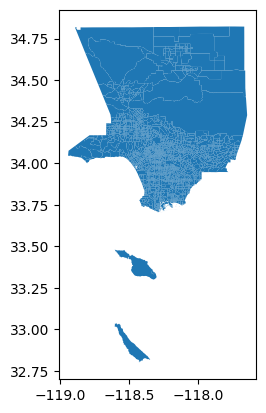

In [131]:
# Plot the LA County Census Tracts to validate the filter
la_county_census_tracts_gdf.plot()

To see the full statewide dataset and verify our LA County filter worked correctly, we can plot all California census tracts with each county shown in a different color. 

The **`column='COUNTYFP'`** parameter tells GeoPandas to color the tracts based on the `COUNTYFP` (County FIPS code) values, and **`cmap='tab20'`** specifies a colormap with 20 distinct colors—ideal for distinguishing multiple counties.

<Axes: >

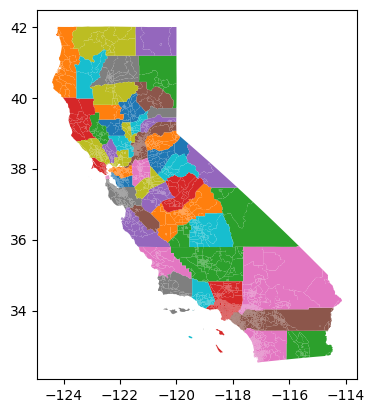

In [132]:
# Plot the California Census Tracts to see all tracts
# Use 'COUNTYFP' to color by county
ca_census_tracts_gdf.plot(column='COUNTYFP')

### Select by Location

Beyond attribute filtering, GeoPandas enables **spatial filtering** based on geometric relationships between features. This is one of the most powerful aspects of GIS analysis.

The **`.intersects()`** method tests whether geometries spatially overlap or touch each other. In this example, we filter the statewide railway dataset to find only the railway segments that intersect with LA County's boundary.

**Spatial relationship methods in GeoPandas:**
- `.intersects()` - geometries overlap or touch
- `.contains()` - one geometry fully contains another
- `.within()` - one geometry is fully inside another
- `.touches()` - geometries share a boundary but don't overlap
- `.crosses()` - geometries intersect but don't contain each other

**Read more**: 
* [GeoPandas and Spatial Relationships](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.intersects.html)
* [Shapely and Spatial Relationships](https://shapely.readthedocs.io/en/latest/manual.html#predicates-and-relationships)

*Figure: A polygon intersects polylines*

<img src=img/polygon-intersect-polyline.png width=30%/>

<Axes: >

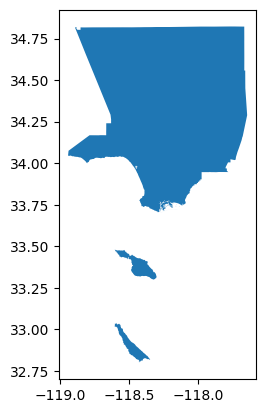

In [133]:
# Plot LA County Boundary
la_county_boundary_gdf.plot()

In [134]:
# Get the geometry of the LA County boundary
la_county_boundary_gdf.loc[0, 'geometry']

# Print the geometry of the LA County boundary
print(type(la_county_boundary_gdf.loc[0, 'geometry']))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


The `.intersects()` method tests each railway segment (LineString geometry) against the LA County boundary polygon:

**Process:**
1. Takes each railway LineString from the statewide dataset
2. Checks if it spatially intersects with the LA County boundary polygon
3. Returns `True` if the railway crosses or touches the boundary, `False` otherwise
4. Creates a boolean mask for filtering

This efficiently identifies all railway segments that pass through LA County.

|Railway Segment| LA Boundary| IS_INTERSECT?|
|:----:|:----:|----|
|<img src=img/railway_segment.png width=50% />|<img src=img/la_boundary.png width=50% />|True|
|<img src=img/railway_segment.png width=50% />|<img src=img/la_boundary.png width=50% />|True|
|<img src=img/railway_segment.png width=50% />|<img src=img/la_boundary.png width=50% />|<p style="color:red">False</p>|
|...|...|...|
|<img src=img/railway_segment.png width=50% />|<img src=img/la_boundary.png width=50% />|True|

0        False
1        False
2        False
3        False
4        False
         ...  
17121    False
17122    False
17123    False
17124     True
17125    False
Length: 17126, dtype: bool


<Axes: >

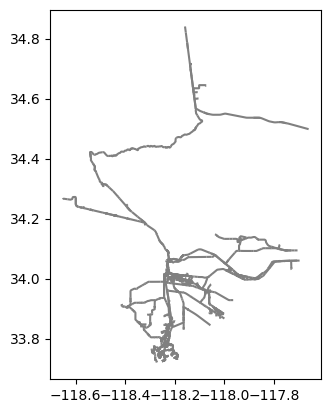

In [135]:
# Read California Railway Shapefile
ca_railway_gdf = gpd.read_file(ca_railway)

# Select railways that intersect with LA County boundary using spatial relationship
# This creates a boolean mask where True means the railway intersects LA County
where_clause = ca_railway_gdf.geometry.intersects(la_county_boundary_gdf.loc[0, 'geometry'])
print(where_clause)

# Apply the spatial filter
la_railway_gdf = ca_railway_gdf[where_clause]

# Display the filtered railway features
la_railway_gdf.plot(color='gray')

# Display the California railway features
# ca_railway_gdf.plot()

### Read Tables

For non-spatial tabular data (like CSV files), we use **pandas** instead of GeoPandas. The **`pd.read_csv()`** function reads CSV files and returns a standard DataFrame without geometry columns.

In [136]:
import pandas as pd

# Read Tables
ca_census_table_df = pd.read_csv(ca_census_table)   

# Display the first few rows of the DataFrame
ca_census_table_df.head()

GISJOIN  YEAR STUSAB                 GEOID     GEOCODE  REGIONA  \
0  G0100010020100  2020     AL  1400000US01001020100  1001020100        3   
1  G0100010020200  2020     AL  1400000US01001020200  1001020200        3   
2  G0100010020300  2020     AL  1400000US01001020300  1001020300        3   
3  G0100010020400  2020     AL  1400000US01001020400  1001020400        3   
4  G0100010020501  2020     AL  1400000US01001020501  1001020501        3   

   DIVISIONA    STATE  STATEA          COUNTY  ...  U7J002  U7J003  U7J004  \
0          6  Alabama       1  Autauga County  ...    1389     213       5   
1          6  Alabama       1  Autauga County  ...     842    1104       2   
2          6  Alabama       1  Autauga County  ...    2244     714      12   
3          6  Alabama       1  Autauga County  ...    3578     327      17   
4          6  Alabama       1  Autauga County  ...    3241     632      29   

   U7J005  U7J006  U7J007  U7J008  U8R001  U8R002  U8R003  
0       8       3      35     122    40.6    39.8    42.1  
1      12       4      20      71    38.8    36.3    40.6  
2      14       6      49     177    38.8    36.8    41.0  
3      32       1      38     253    43.8    41.0    46.6  
4      93       2      58     267    40.6    38.6    42.6  

[5 rows x 71 columns]

In [137]:
# Filter for Los Angeles County
where_clause = ca_census_table_df['COUNTY'] == 'Los Angeles County'

# Select relevant columns
use_col = ['GISJOIN', 'NAME', 'U7H001']

# Apply filter and select columns
la_county_census_table_df = ca_census_table_df[where_clause][use_col]

# Rename the population column for clarity
la_county_census_table_df = la_county_census_table_df.rename(columns={'U7H001': 'POPULATION'})

# Display the filtered DataFrame
la_county_census_table_df.head()

GISJOIN                  NAME  POPULATION
5584  G0600370101110  Census Tract 1011.10        4926
5585  G0600370101122  Census Tract 1011.22        3728
5586  G0600370101220  Census Tract 1012.20        3344
5587  G0600370101221  Census Tract 1012.21        3444
5588  G0600370101222  Census Tract 1012.22        2808

### Visualize with `.explore()`

GeoPandas' **`.explore()`** method creates interactive web-based maps directly in your notebook. Unlike `.plot()` which produces static matplotlib images, `.explore()` generates an interactive map. 

It uses the same parameters as `.plot()` (like `column` and `cmap`), making it easy to switch between static and interactive visualizations.

In [138]:
# Plot using .explore() for interactive map
# Use 'COUNTYFP' to color by county
# ca_census_tracts_gdf.explore(column='COUNTYFP', 
#                              cmap='tab20',
#                              tooltip=["COUNTYFP"],
#                              popup=True,
#                              legend=False,)

### Visualize with Interactive Map

While matplotlib `.plot()` creates static maps, **[Leafmap](https://leafmap.org/)** enables us to create interactive web maps effortlessly. 

With just a few lines of code, we can add geospatial layers, zoom, pan, and explore our data dynamically—perfect for presentations and exploratory analysis.

In [139]:
import leafmap

# Create a leafmap Map object
m = leafmap.Map()

# Add the LA County boundary to the map
m.add_gdf(la_county_boundary_gdf, layer_name='LA County Boundary')

# Zoom to the extent of the LA County boundary
m.zoom_to_gdf(la_county_boundary_gdf)

# Display the map
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Rasterio and Rasters

**Rasterio** reads and writes geospatial raster data (satellite imagery, elevation models, gridded environmental data).

Unlike vector data (points, lines, polygons), **raster data** represents information as a grid of cells (pixels), where each cell contains a value.

**Key capabilities:**
- Read/write raster formats (GeoTIFF, etc.)
- Access metadata (CRS, resolution, dimensions)
- Perform raster operations (clip, reproject, extract values)
- Integrate with NumPy for analysis

We'll use Rasterio to work with the California Wildfire Hazard Potential raster and clip it to LA County.

**Read more**: [Rasterio Documentation](https://rasterio.readthedocs.io/)

### Import Rasterio

In [140]:
import rasterio

### Read Rasters

Reading raster data with Rasterio uses a **context manager** (`with` statement) to safely open and close files, ensuring proper resource management.

**`rasterio.open()`** opens a raster file and provides access to its properties. 

The example below reads only the metadata without loading the full raster array into memory—efficient for inspecting large files before processing.

In [141]:
# Read the California WHP raster file and access metadata
with rasterio.open(ca_whp) as src:
    ca_whp_meta = src.meta # Metadata
    ca_whp_shape = src.shape # Width and height
    ca_whp_transform = src.transform # Affine transformation
    ca_whp_crs = src.crs # Cordinate Reference System
    ca_whp_nodata = src.nodata # Nodata value

print(f"Raster shape: {ca_whp_shape}")
print(f"CRS: {ca_whp_crs}")
print(f"Spatial resolution: 270m")
print(f"Nodata value: {ca_whp_nodata}")
print(f"\nMetadata: {ca_whp_meta}")

Raster shape: (4484, 2629)
CRS: EPSG:5070
Spatial resolution: 270m
Nodata value: 255.0

Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 2629, 'height': 4484, 'count': 1, 'crs': CRS.from_wkt('PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]'), 'transform': Affine(270.0, 0.0, -2356155.000000001,
       0.0, -270.0, 2452814.999999998)}


To work with actual pixel values, use **`.read(band_number)`** to load raster data into a NumPy array. The parameter specifies which band to read (1 for the first band). 

This returns a 2D array where each element represents a pixel's value—in our case, wildfire hazard levels (1-7). NumPy arrays enable fast numerical operations and analysis on large raster datasets.

In [142]:
# Read the California WHP raster file, and access first band
with rasterio.open(ca_whp) as src:
    ca_whp_data = src.read(1)  # Read the first band

print(f"Raster data: \n {ca_whp_data}")
print(f"Raster shape (row, col): {ca_whp_data.shape}")
print(f"Data type: {type(ca_whp_data)}")

Raster data: 
 [[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
Raster shape (row, col): (4484, 2629)
Data type: <class 'numpy.ndarray'>


### Raster Data Structure

Raster data is stored as a 2D array where rows and columns correspond to spatial positions:

```python
[[  278.7   277.9   278.0   281.2   287.2]
 [  282.9   285.3   294.2   278.4   286.9]
 [  298.6   299.1   294.8   281.2   275.6]
 [  297.6   280.0   290.9   281.4   287. ]
 [  297.2 -9999.0   297.9   275.4   278.3]]
```

Each cell contains a value representing temperature at that geographic location.

<img src="https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/GUID-885FD35E-8680-4FFE-A3D7-76E473F31B76-web.gif" width=50% />

*Figure: Raster data structure*

https://pro.arcgis.com/en/pro-app/latest/help/data/imagery/introduction-to-raster-data.htm

### Clip Raster with Vector

One of the most common raster operations is **clipping**—extracting a subset of a raster using a vector boundary. This reduces file size and focuses analysis on a specific area of interest.

**Key steps:**
1. **Reproject vector to match raster CRS**: Use `.to_crs()` to ensure both datasets share the same coordinate system—required for accurate spatial operations
2. **Apply mask with `crop=True`**: The `mask()` function from `rasterio.mask` clips the raster to the vector boundary and returns:
   - `out_image`: The clipped raster data as a NumPy array
   - `out_transform`: Updated affine transform for the new extent
3. **Update metadata**: Modify dimensions (`height`, `width`) and `transform` to reflect the clipped extent

This workflow is essential for focusing large datasets on specific study areas, like extracting LA County from the statewide California raster.

Read more: [Masking by shapefile](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html)

<img src="https://content.esri.com/blogs/images/dev_25610.jpg" width=50%>

*Figure: Clip Raster*

https://www.esri.com/arcgis-blog/products/product/analytics/clipping-an-image-or-raster-in-arcgis

In [143]:
from rasterio.mask import mask
import rasterio

# Reproject LA County boundary to match the raster CRS if needed
la_county_boundary_reprojected = la_county_boundary_gdf.to_crs(ca_whp_crs)

# Clip the California WHP raster with LA County boundary
with rasterio.open(ca_whp) as src:
    # Mask the raster with the LA County boundary geometry
    out_image, out_transform = mask(src, la_county_boundary_reprojected.geometry, crop=True)
    out_meta = src.meta.copy()
    
    # Update metadata for the clipped raster
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

### Write Raster

After processing raster data (clipping, calculations, etc.), you'll often need to save the results to a new file. Rasterio uses the same context manager pattern for writing as reading.

**Key parameters for `rasterio.open()` in write mode:**
- **First argument**: Output file path
- **`"w"` mode**: Opens file for writing (creates new file or overwrites existing)
- **`**out_meta`**: Unpacks the metadata dictionary to configure the output file (format, dimensions, CRS, data type, etc.)

The **`.write()`** method saves the raster array to disk. This creates a permanent GeoTIFF file that can be used in subsequent analysis or shared with others.

In [144]:
# Save the clipped raster
output_tif = "data/raster/la_county_whp.tif"
with rasterio.open(output_tif, "w", **out_meta) as dest:
    dest.write(out_image)

print(f"Clipped raster saved to {output_tif}")

Clipped raster saved to data/raster/la_county_whp.tif


We read this saved GeoTIFF for future analysis.

In [145]:
# Path to the clipped LA County WHP raster
la_county_whp = 'data/raster/la_county_whp.tif'

# Read LA County WHP raster
with rasterio.open(la_county_whp) as src:
    la_county_whp_rio = src.read(1)
    la_county_whp_transform = src.transform
    la_county_whp_crs = src.crs

### Visualize Raster

Rasterio provides **`show()`** from `rasterio.plot` for quick raster visualization using matplotlib. 

**Key parameters:**
- **First argument**: The raster array (NumPy array) to display
- **`transform`**: The affine transform to correctly position the raster in geographic space

With default settings, `show()` displays the raster with a default colormap. To create more informative visualizations (custom colors, legends, titles), you can combine `show()` with matplotlib's plotting features.

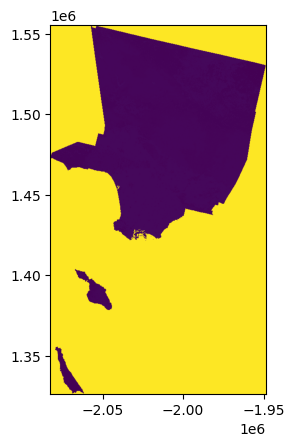

<Axes: >

In [146]:
from rasterio.plot import show

# Visualize the clipped LA County WHP raster
show(la_county_whp_rio, transform=la_county_whp_transform)

When visualizing raster data with `show()`, the **`transform`** parameter is optional but important:

The example below demonstrates how the same raster appears without geographic referencing - notice the axes show pixel indices instead of coordinates.

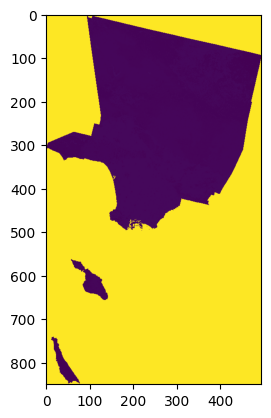

<Axes: >

In [147]:
# Visualize the clipped LA County WHP raster without transform
show(la_county_whp_rio)

### Visualize with Color Maps (Optional)

For more informative visualizations, we can combine Rasterio's `show()` with **matplotlib customization** to create publication-quality maps with custom colormaps and legends.

**Key customization steps:**

1. **Create custom colormap** - Use `ListedColormap()` to define specific colors for each WHP category (1-7)
2. **Configure matplotlib figure** - Set up figure size and axes with `plt.subplots()`
3. **Set colormap range** - Use `vmin` and `vmax` parameters to match WHP values (1-7)
4. **Add colorbar with labels** - Create a legend showing color-to-category mapping

This approach gives you full control over colors, titles, legends, and layout—essential for creating clear, interpretable wildfire risk maps.

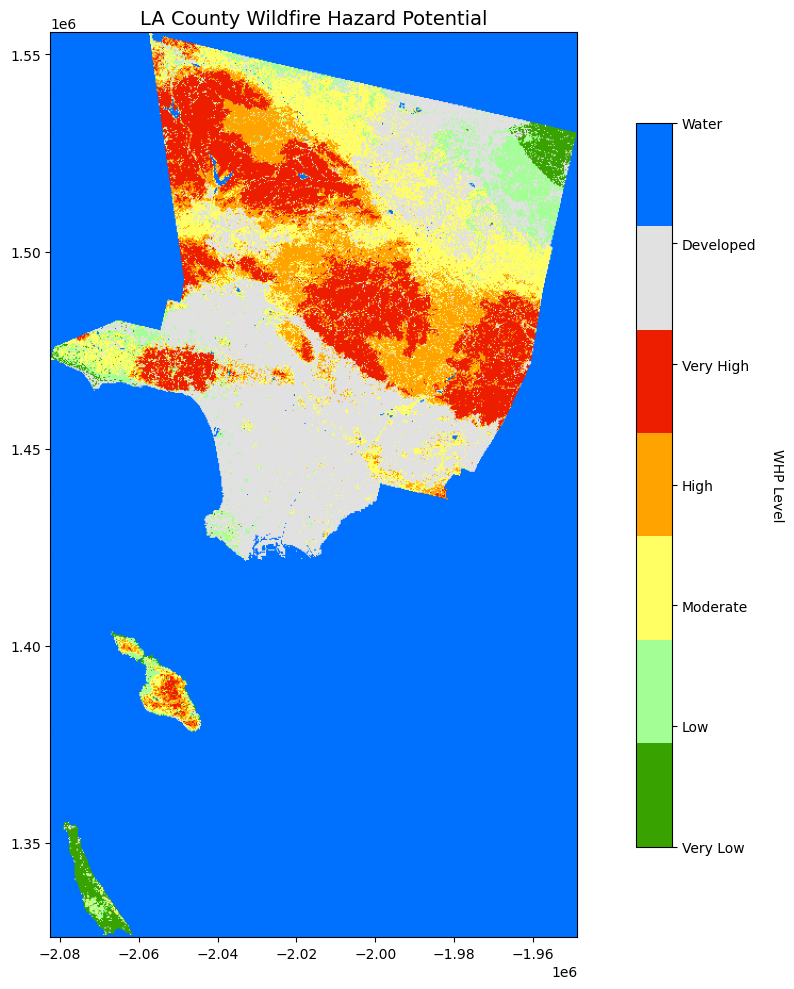

In [148]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

# Create custom colormap
# Values 1-5: green to red gradient, 6: gray (developed), 7: lightblue (water)
# colors = ['green', 'yellow', 'orange', 'darkorange', 'red', 'gray', 'lightblue']
colors = ['#38A300', '#A3FF95', '#FFFF64', '#FFA301', '#ED1E00', '#E1E1E1', '#0070FF']
cmap = ListedColormap(colors)

# Display the clipped LA County WHP raster with custom colormap
fig, ax = plt.subplots(figsize=(12, 10))

# Use rasterio.plot.show with the clipped output
show(la_county_whp_rio, 
     transform=la_county_whp_transform, 
     ax=ax, 
     cmap=cmap,
     vmin=1, # set minimum value for colormap
     vmax=7, # set maximum value for colormap
     ) 

# Set title
ax.set_title('LA County Wildfire Hazard Potential', fontsize=14)

# Add colorbar with labels
im = ax.images[0]
cbar = plt.colorbar(im, ax=ax, ticks=[1, 2, 3, 4, 5, 6, 7], shrink=0.8)
cbar.set_label('WHP Level', rotation=270, labelpad=20)
cbar.ax.set_yticklabels(['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Developed', 'Water'])

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Visualize with Interactive Map

While matplotlib creates static visualizations, **Leafmap's `.add_raster()`** method enables interactive raster exploration in web-based maps.

**Key parameters for `.add_raster()`:**
- **First argument**: Path to the raster file (GeoTIFF)
- **`layer_name`**: Display name for the layer in the map legend
- **`colormap`**: List of colors matching raster values (reuses our custom WHP colors)
- **`vmin` and `vmax`**: Define the value range for color mapping (1-7 for WHP levels)

This combines the custom colormap from matplotlib with Leafmap's interactive features—zoom, pan, and layer toggling—ideal for exploring spatial patterns in wildfire hazard data.

In [149]:
# Create a leafmap Map object
m = leafmap.Map()

# Define custom colormap
# colors = ['green', 'yellow', 'orange', 'darkorange', 'red', 'gray', 'lightblue']
colors = ['#38A300', '#A3FF95', '#FFFF64', '#FFA301', '#ED1E00', '#E1E1E1', '#0070FF']

# Add the LA County WHP raster to the leafmap with custom colormap
m.add_raster(la_county_whp, layer_name='LA County WHP', colormap=colors, vmin=1, vmax=7)

# Add the colormap to the map
m.add_legend(title="Wildfire Hazard Potential", 
             labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High', 'Developed', 'Water'], 
             colors=colors)

# Show the map
m

Map(center=[33.907641999999996, -118.166902], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

## Spatial Analysis

Now that we've learned to work with vector and raster data, we'll apply these skills to conduct spatial analysis for wildfire risk assessment. This section demonstrates three essential GIS analysis techniques:

**Key spatial analysis methods:**

1. **Table Join** - Combine census population data with census tract geometries using attribute relationships
2. **Geometric Operations** - Create buffer zones around railways and calculate population density
3. **Zonal Statistics** - Extract raster statistics (WHP values) within vector boundaries to quantify wildfire risk

By integrating these methods, we'll identify high-risk areas and populations vulnerable to wildfires across LA County.

### Table Join

Our census tract geometries currently lack population data, which is stored separately in the census table. To combine them, we'll perform a **table join**—a fundamental operation that merges tabular data with spatial data based on a common attribute.

**Key parameters for `.merge()`:**
- **First argument**: The DataFrame to join (census table with population data)
- **`on='GISJOIN'`**: The common field linking both datasets (unique census tract identifier)
- **`how='left'`**: Keep all census tracts and add matching population data where available

This creates a unified GeoDataFrame with both spatial geometries and population attributes, enabling demographic-based wildfire risk analysis.

*Figure: Join*

https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/add-join.htm

<img src="https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/GUID-C441B51F-B581-4743-A975-3EB04087838C-web.gif" width=50%>

In [150]:
# Join census table to census tracts
la_county_census_tracts_gdf = la_county_census_tracts_gdf.merge(
    la_county_census_table_df, # Census table with population data
    on='GISJOIN',              # Join on the GISJOIN field
    how='left'                 # Keep all census tracts and add matching population data
)

# Display the first few rows of the joined GeoDataFrame
la_county_census_tracts_gdf.head()

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID   NAME_x  \
0  G0600370101110      06      037  101110  06037101110  1011.10   
1  G0600370101122      06      037  101122  06037101122  1011.22   
2  G0600370101220      06      037  101220  06037101220  1012.20   
3  G0600370101221      06      037  101221  06037101221  1012.21   
4  G0600370101222      06      037  101222  06037101222  1012.22   

               NAMELSAD  MTFCC FUNCSTAT      ALAND  AWATER     INTPTLAT  \
0  Census Tract 1011.10  G5020        S  1142401.0     0.0  +34.2594737   
1  Census Tract 1011.22  G5020        S  2644045.0     0.0  +34.2677213   
2  Census Tract 1012.20  G5020        S   698886.0     0.0  +34.2516083   
3  Census Tract 1012.21  G5020        S   354178.0     0.0  +34.2543290   
4  Census Tract 1012.22  G5020        S   296512.0     0.0  +34.2513519   

       INTPTLON   Shape_Leng    Shape_Area  \
0  -118.2929869  4585.520052  1.142400e+06   
1  -118.2901465  9652.233049  2.644046e+06   
2  -118.2816328  3870.684865  6.988841e+05   
3  -118.2925767  2781.494135  3.541765e+05   
4  -118.2885261  3042.743329  2.965130e+05   

                                            geometry                NAME_y  \
0  POLYGON ((-118.29792 34.26322, -118.29696 34.2...  Census Tract 1011.10   
1  POLYGON ((-118.27742 34.2599, -118.27746 34.25...  Census Tract 1011.22   
2  POLYGON ((-118.28498 34.25589, -118.28449 34.2...  Census Tract 1012.20   
3  POLYGON ((-118.28733 34.2559, -118.28733 34.25...  Census Tract 1012.21   
4  POLYGON ((-118.28592 34.2559, -118.28592 34.25...  Census Tract 1012.22   

   POPULATION  
0        4926  
1        3728  
2        3344  
3        3444  
4        2808

In [151]:
# Select relevant columns to keep
use_col = ['GISJOIN', 'STATEFP', 'COUNTYFP', 'ALAND', 'AWATER', 'POPULATION', 'geometry']
la_county_census_tracts_gdf = la_county_census_tracts_gdf[use_col]
la_county_census_tracts_gdf.head()

GISJOIN STATEFP COUNTYFP      ALAND  AWATER  POPULATION  \
0  G0600370101110      06      037  1142401.0     0.0        4926   
1  G0600370101122      06      037  2644045.0     0.0        3728   
2  G0600370101220      06      037   698886.0     0.0        3344   
3  G0600370101221      06      037   354178.0     0.0        3444   
4  G0600370101222      06      037   296512.0     0.0        2808   

                                            geometry  
0  POLYGON ((-118.29792 34.26322, -118.29696 34.2...  
1  POLYGON ((-118.27742 34.2599, -118.27746 34.25...  
2  POLYGON ((-118.28498 34.25589, -118.28449 34.2...  
3  POLYGON ((-118.28733 34.2559, -118.28733 34.25...  
4  POLYGON ((-118.28592 34.2559, -118.28592 34.25...

### Calculate a New Attribute

After table join, we can calculate population density by dividing the **Population** by the **Land Area (in $\text{km}^2$)**.

The population density ($D$) is defined as:

$$D = \frac{\text{POPULATION}}{\frac{\text{ALAND}}{10^6}}$$

**Key:**

  * **D**: Population Density ($\text{people}/\text{km}^2$)
  * **POPULATION**: Total population count.
  * **ALAND**: Land area in $\text{m}^2$.
  * **$10^6$**: Conversion factor to change $\text{m}^2$ to $\text{km}^2$.

In [152]:
# Calculate population density (people per square kilometer)
la_county_census_tracts_gdf['POP_KM2'] = la_county_census_tracts_gdf['POPULATION'] / (la_county_census_tracts_gdf['ALAND'] / 1e6)
la_county_census_tracts_gdf.head()

GISJOIN STATEFP COUNTYFP      ALAND  AWATER  POPULATION  \
0  G0600370101110      06      037  1142401.0     0.0        4926   
1  G0600370101122      06      037  2644045.0     0.0        3728   
2  G0600370101220      06      037   698886.0     0.0        3344   
3  G0600370101221      06      037   354178.0     0.0        3444   
4  G0600370101222      06      037   296512.0     0.0        2808   

                                            geometry      POP_KM2  
0  POLYGON ((-118.29792 34.26322, -118.29696 34.2...  4311.971015  
1  POLYGON ((-118.27742 34.2599, -118.27746 34.25...  1409.960874  
2  POLYGON ((-118.28498 34.25589, -118.28449 34.2...  4784.757457  
3  POLYGON ((-118.28733 34.2559, -118.28733 34.25...  9723.924129  
4  POLYGON ((-118.28592 34.2559, -118.28592 34.25...  9470.105763

### Geometric Operations

GeoPandas provides powerful methods to transform and analyze vector geometries using **Shapely**. These operations create new spatial features, enabling advanced spatial analysis.

**Common geometric operations:**
- **`.centroid`** - Calculates the geometric center point of each polygon
- **`.buffer(distance)`** - Creates a polygon around features at a specified distance
- **`.dissolve()`** - Merges adjacent or overlapping geometries into a single feature

**Read more**: [Shapely onstructive operations](https://shapely.readthedocs.io/en/stable/constructive.html)

In [153]:
# Create centroids of census tracts
centroids_gdf = la_county_census_tracts_gdf.geometry.centroid

# Visualize centroids
centroids_gdf.head(100).explore(color='black')

In [154]:
# Create buffer of railways
# It is important to project to an appropriate CRS for distance-based operations
buffer_gdf = la_railway_gdf.to_crs(epsg=5070)
buffer_gdf['geometry'] = buffer_gdf.geometry.buffer(270)

# Display the buffer
buffer_gdf.head(100).explore()

In [155]:
# Dissolve the buffer
buffer_dissolve_gdf = buffer_gdf.dissolve()

# Display the buffer
buffer_dissolve_gdf.explore()

### Zonal Statistics

**Zonal statistics** is a powerful technique that extracts summary statistics from raster data within vector boundaries (zones). We'll use the **`zonal_stats()`** function from the `rasterstats` library to analyze wildfire hazard potential within each census tract.

**How it works:**
- **Zones**: Census tract polygons (each identified by `GISJOIN`)
- **Raster values**: WHP classifications (1-7) from the wildfire hazard raster
- **Statistics**: Count of cells for each WHP category, or summary metrics

**Available statistics:**
- `categorical=True`: Counts of each unique raster value (ideal for classified data like WHP)
- Standard statistics: `min`, `max`, `mean`, `median`, `sum`, `std`, `count`, `range`

Let's start by calculating zonal statistics for a single census tract to understand the distribution of wildfire hazard classes within that area.

**Read more**: [More statistics](https://pythonhosted.org/rasterstats/manual.html#statistics), [How zonal statistics works](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-zonal-statistics-works.htm)

<img src="img/zonal-stats.png" width=80%>

*Figure: Zonal Statistics*

In [156]:
# Sample one record from la_county_census_tracts_gdf
# sample_tract = la_county_census_tracts_gdf.sample(n=1)

where_clause = la_county_census_tracts_gdf['GISJOIN'] == 'G0600370800504'
sample_tract = la_county_census_tracts_gdf[where_clause]

# Print sample tract details
print(f"Sampled Census Tract: {sample_tract['GISJOIN'].values[0]}")
print(f"Population: {sample_tract['POPULATION'].values[0]}")
print(f"Area (km²): {sample_tract['ALAND'].values[0] / 1e6:.2f}")

# Explore the sample tract
sample_tract.explore()

Sampled Census Tract: G0600370800504
Population: 2261
Area (km²): 21.59


Importing the **`zonal_stats`** function from the **`rasterstats`** package is the correct way to start.

In [157]:
from rasterstats import zonal_stats

In [158]:
# Get cell count within the sample tract
count = zonal_stats(
    sample_tract.to_crs(la_county_whp_crs), # Reproject to match raster CRS
    la_county_whp, # LA County WHP raster
    stats=['count'], # Get count of all pixels within sample tract
    nodata=255 # Handle NoData values
)

count

[{'count': 293}]

In [159]:
# Get multiple statistics: count, min, max, mean
multiple_stats = zonal_stats(
    sample_tract.to_crs(la_county_whp_crs), # Reproject to match raster CRS
    la_county_whp, # LA County WHP raster
    stats=['count', 'min', 'max', 'mean'], # Get count of all pixels within sample tract
    nodata=255 # Handle NoData values
)

multiple_stats

[{'min': 1.0, 'max': 7.0, 'mean': 4.583617747440273, 'count': 293}]

Now we'll calculate the categorical statistics to count how many raster cells fall into each WHP category within the sample census tract.

**Key parameters for `zonal_stats()`:**
- **First argument**: Vector geometries (reprojected to match raster CRS)
- **Second argument**: Path to the raster file
- **`categorical=True`**: Returns counts for each unique raster value instead of summary statistics
- **`nodata=-255`**: Specifies which raster values to ignore as missing data

The result is a dictionary where keys are WHP values (1-7) and values are the number of raster cells with that classification.# Plot the value_counts of WHP values

In [160]:
# Calculate value_counts of cell values from ca_whp.tif using zonal_stats
# Use categorical=True to get counts of each unique value
unique_count = zonal_stats(
    sample_tract.to_crs(la_county_whp_crs), # Reproject to match raster CRS
    la_county_whp, # LA County WHP raster
    categorical=True, # Use categorical=True to get counts of each unique value
    nodata=255 # Handle NoData values
)

# Extract the value counts from the first (and only) record
whp_value_counts = unique_count[0]
print("WHP Value Counts:")
print(whp_value_counts)

WHP Value Counts:
{1: 3, 2: 23, 3: 30, 4: 60, 5: 100, 6: 75, 7: 2}


### Plot Zonal Statistics (Optional)

To better understand the wildfire hazard distribution, let's visualize the results with a bar chart showing the count of cells in each WHP category.

The following code creates a color-coded bar chart using matplotlib. While understanding the detailed matplotlib code is optional (not the focus of this course), you can use GenAI tools to explain specific parts if you're curious about the visualization techniques.

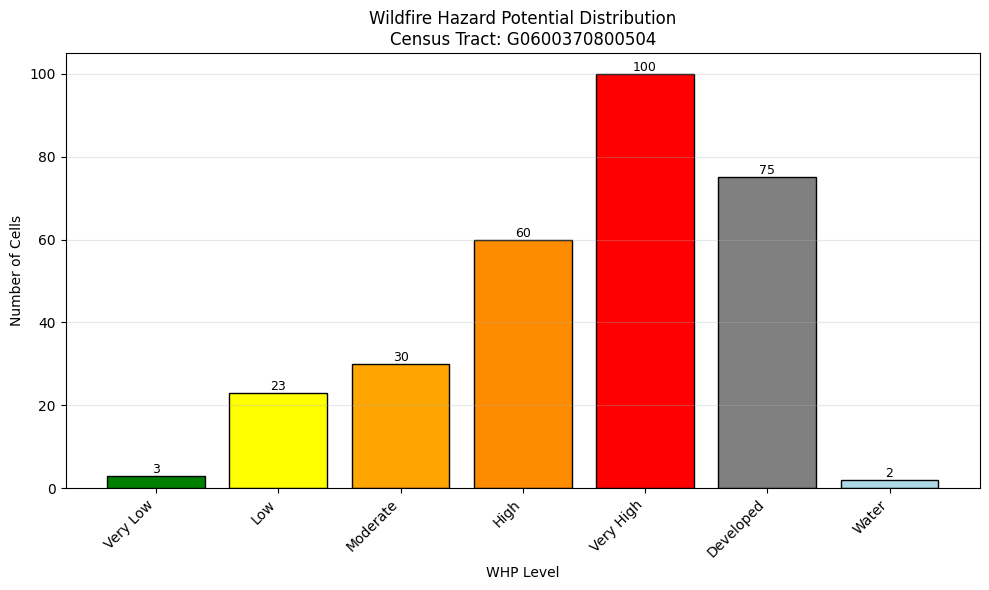

In [161]:
import matplotlib.pyplot as plt

# Convert to pandas Series for easier plotting
whp_series = pd.Series(whp_value_counts)
whp_series = whp_series.sort_index()

# Define WHP labels
whp_labels = {
    1: 'Very Low',
    2: 'Low',
    3: 'Moderate',
    4: 'High',
    5: 'Very High',
    6: 'Developed',
    7: 'Water'
}

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
colors_map = {1: 'green', 2: 'yellow', 3: 'orange', 4: 'darkorange', 5: 'red', 6: 'gray', 7: 'lightblue'}
bar_colors = [colors_map.get(int(x), 'blue') for x in whp_series.index]

bars = ax.bar(range(len(whp_series)), whp_series.values, color=bar_colors, edgecolor='black')
ax.set_xticks(range(len(whp_series)))
ax.set_xticklabels([whp_labels.get(int(x), f'Value {x}') for x in whp_series.index], rotation=45, ha='right')
ax.set_ylabel('Number of Cells')
ax.set_xlabel('WHP Level')
ax.set_title(f'Wildfire Hazard Potential Distribution\nCensus Tract: {sample_tract["GISJOIN"].values[0]}')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, whp_series.values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
            f'{int(value):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Wildfire Risk Assessment

Now we'll integrate all the techniques learned in this workshop to perform a wildfire risk assessment for Los Angeles County. This analysis combines vector operations, raster analysis, and zonal statistics to answer critical questions:

**Key research questions:**
1. **Population exposure**: Which census tracts have more people exposed to wildfire risk?
2. **Infrastructure vulnerability**: Which railway segments are more exposed to wildfire hazards?

**Analysis workflow:**
- Apply zonal statistics to all census tracts and railway buffers
- Calculate percentage of high-risk areas (WHP categories 4 and 5) for each geographic unit
- Visualize results with choropleth maps to identify spatial patterns
- Identify vulnerable populations and critical infrastructure in high-risk zones

This integrated approach demonstrates how GIS analysis can inform emergency planning, resource allocation, and risk mitigation strategies.

### Define Key Functions

To streamline our risk assessment workflow, we'll create two reusable Python functions that automate the zonal statistics calculations for any geographic unit (census tracts, railway buffers, etc.).

**Function 1: `calculate_whp_count_by_geometry(geometry)`**

This function counts the number of raster cells for each WHP category within a given geometry and returns the results as a dictionary.

**Parameters:**
- `geometry`: A shapely geometry object (polygon, multipolygon)

**Returns:**
- Dictionary with WHP values (1-7) as keys and cell counts as values, plus a `'total'` key for the total cell count

**Example output:**
```python
{
    1: 3,          # Very Low: 3 cells
    2: 23,         # Low: 23 cells
    3: 30,         # Moderate: 30 cells
    4: 60,         # High: 60 cells
    5: 100,        # Very High: 100 cells
    6: 75,         # Developed: 75 cells
    7: 2,          # Water: 2 cells
    'total': 293   # Total cells in geometry
}
```

In [ ]:
def calculate_whp_count_by_geometry(geometry):
    """
    Calculate the value counts of WHP raster cells within a given geometry.
    
    Parameters:
    -----------
    geometry : shapely geometry
        The geometry to calculate WHP value counts for
    
    Returns:
    --------
    dict
        Dictionary with WHP values as keys and counts as values
    """
    # Calculate WHP value counts using zonal_stats
    unique_count = zonal_stats(
        [geometry],
        la_county_whp,
        categorical=True,
        nodata=-9999
    )

    # Calculate total count of all cells within the geometry
    all_stats = zonal_stats(        
        [geometry],
        la_county_whp,
        categorical=False,
        nodata=-9999)

    # Print all stats. e.g., {'count': 150, 'min': 1, 'max': 7, 'mean': 3.5, 'sum': 525}
    print(all_stats)

    # Combine unique counts with total count
    whp_counts = unique_count[0]
    whp_counts['total'] = all_stats[0]['count']
    
    return whp_counts

# Test the function with one random geometry
test_geometry = la_county_census_tracts_gdf.to_crs(la_county_whp_crs).sample(1).geometry.values[0]
test_result = calculate_whp_count_by_geometry(test_geometry)
print("Test result:", test_result)

**Function 2: `calculate_pct_high_risk(whp_counts)`**

This function calculates the percentage of high-risk cells (WHP categories 4 and 5) from the dictionary returned by the first function.

**Formula:**
$$
\%\text{ High Risk} = \frac{\text{High Risk Cells} + \text{Very High Risk Cells}}{\text{Total Cells}} \times 100
$$
or
$$
\%\text{ High Risk} = \frac{WHP_4 + WHP_5}{\text{Total}} \times 100
$$

**Parameters:**
- `whp_counts`: Dictionary output from `calculate_whp_count_by_geometry()`

**Returns:**
- Float representing the percentage of high-risk cells (0-100)

These functions enable us to efficiently analyze wildfire risk across hundreds of census tracts and railway segments with consistent methodology.

In [ ]:
# Calculate pct_high_risk column
# High risk = WHP values 4 (High) and 5 (Very High)

def calculate_pct_high_risk(whp_counts):
    """
    Calculate the percentage of high-risk areas (WHP 4 and 5) from whp_counts dictionary.
    
    Parameters:
    -----------
    whp_counts : dict
        Dictionary with WHP values as keys and counts as values, including 'total'
    
    Returns:
    --------
    float
        Percentage of high-risk cells (0-100)
    """
    if not whp_counts or whp_counts.get('total', 0) == 0:
        return 0.0
    
    # Get counts for WHP 4 (High) and 5 (Very High)
    high_count = whp_counts.get(4, 0)
    very_high_count = whp_counts.get(5, 0)
    total_count = whp_counts.get('total', 0)
    
    # Calculate percentage
    pct_high_risk = ((high_count + very_high_count) / total_count) * 100
    
    return round(pct_high_risk, 2)

# Test the function with sample WHP counts
sample_whp_counts = {
    1: 3,          # Very Low: 3 cells
    2: 23,         # Low: 23 cells
    3: 30,         # Moderate: 30 cells
    4: 60,         # High: 60 cells
    5: 100,        # Very High: 100 cells
    6: 75,         # Developed: 75 cells
    7: 2,          # Water: 2 cells
    'total': 293   # Total cells in geometry
}
pct_high_risk = calculate_pct_high_risk(sample_whp_counts)
print(f"Percentage of high-risk areas: {pct_high_risk}%")

### Wildfire Risk to Population

In [ ]:
# Reproject census tracts to match raster CRS
print("Reprojecting census tracts to match raster CRS...")
la_county_census_tracts_reprojected = la_county_census_tracts_gdf.to_crs(la_county_whp_crs)

# Apply the function to each row and store in new column 'whp_counts'
print("Calculating WHP counts for all census tracts...")
la_county_census_tracts_gdf['whp_counts'] = la_county_census_tracts_reprojected.geometry.apply(
    calculate_whp_count_by_geometry
)

print(f"Completed! Added 'whp_counts' column to {len(la_county_census_tracts_gdf)} census tracts")
print("\nFirst few rows with whp_counts:")
la_county_census_tracts_gdf.head()

In [ ]:
# Apply the function to calculate pct_high_risk for each census tract
la_county_census_tracts_gdf['pct_high_risk'] = la_county_census_tracts_gdf['whp_counts'].apply(
    calculate_pct_high_risk
)

# Print summary statistics
print(f"\nTracts with >50% high risk: {(la_county_census_tracts_gdf['pct_high_risk'] > 50).sum()}")
print(f"Tracts with >75% high risk: {(la_county_census_tracts_gdf['pct_high_risk'] > 75).sum()}")

# Display first few rows
la_county_census_tracts_gdf[['GISJOIN', 'POPULATION','pct_high_risk']].head(10)

In [ ]:
la_county_census_tracts_gdf.explore(column='pct_high_risk',
                                 cmap='summer',
                                 legend_name='Percentage of High-Risk Areas (%)',
                                 tooltip=['GISJOIN', 'POPULATION', 'pct_high_risk'],
                                 popup=True)

### Wildfire Risk to Railway

In [ ]:
# Reproject railway to match raster CRS
la_railway_buffer_gdf = la_railway_gdf.to_crs(la_county_whp_crs)

# Create 270m buffer around the railway
print("\nCreating 270m buffer around railway...")
la_railway_buffer_gdf['geometry'] = la_railway_buffer_gdf.geometry.buffer(270)

# Calculate WHP counts for each buffered railway segment
print("\nCalculating WHP counts for buffered railway segments...")
la_railway_buffer_gdf['whp_counts'] = la_railway_buffer_gdf.geometry.apply(
    calculate_whp_count_by_geometry
)

print("\nCompleted WHP analysis for railway buffers!")
print(f"\nFirst few railway segments with WHP counts:")
la_railway_buffer_gdf[['whp_counts']].head()

In [ ]:
# Calculate pct_high_risk for railway buffers using the calculate_pct_high_risk function
print("Calculating pct_high_risk for railway buffers...")
la_railway_gdf['pct_high_risk'] = la_railway_buffer_gdf['whp_counts'].apply(
    calculate_pct_high_risk
)

print(f"\nRailway segments with >50% high risk: {(la_railway_gdf['pct_high_risk'] > 50).sum()}")
print(f"Railway segments with >75% high risk: {(la_railway_gdf['pct_high_risk'] > 75).sum()}")

# Display first few rows with whp_counts and pct_high_risk
print("\nFirst few railway buffer segments with WHP analysis:")
la_railway_gdf[['FRAARCID', 'MILES', 'pct_high_risk']].head(10)

In [ ]:
# Visualize pct_high_risk for railway segments
la_railway_gdf = la_railway_gdf[['FRAARCID', 'MILES', 'pct_high_risk', 'geometry']]
la_railway_gdf.explore(tiles='Esri.WorldImagery', column='pct_high_risk', cmap='Reds', scheme='naturalbreaks')

In [ ]:
# Create a choropleth map of railway segments colored by pct_high_risk
print("Creating choropleth map for railway wildfire risk...")

# Create a new leafmap Map object
railway_map = leafmap.Map(center=[34.05, -118.25], zoom=9)

# Add the railway segments as a choropleth map
railway_map.add_data(
    la_railway_gdf, 
    column='pct_high_risk', 
    scheme='NaturalBreaks', 
    cmap='summer', 
    legend_title='% High Fire Risk (WHP 4 & 5)'
)

# Display the map
print("\nChoropleth map created!")
print("Railway segments are colored by percentage of high fire risk (WHP 4 & 5)")
railway_map

In [ ]:
# Create a choropleth map of census tracts colored by pct_high_risk
print("Creating choropleth map for census tract wildfire risk...")

# Create a new leafmap Map object
census_map = leafmap.Map(center=[34.05, -118.25], zoom=9)

# Add the census tracts as a choropleth map using add_data
census_map.add_data(
    la_county_census_tracts_gdf[['GISJOIN', 'POPULATION', 'pct_high_risk', 'geometry']], 
    column='pct_high_risk', 
    scheme='NaturalBreaks', 
    cmap='summer', 
    legend_title='% High Fire Risk (WHP 4 & 5)'
)

# Display the map
print("\nChoropleth map created!")
print("Census tracts are colored by percentage of high fire risk (WHP 4 & 5)")
print("Click on a tract to see details")
census_map